In [61]:
from __future__ import print_function
import matplotlib.pylab as plt
import pandas as pd
import urllib.request
from urllib import request

In [62]:
import pandas as pd
from plotnine import *
import warnings
warnings.filterwarnings(action='ignore') 

# 1. url 데이터 불러오기

In [4]:
#url로 되어 있는 파일 저장하기
request.urlretrieve('https://www.stoxx.com/document/Indices/Current/HistoricalData/hbrbcpe.txt','es.txt')

('es.txt', <http.client.HTTPMessage at 0x21d51eb1160>)

In [5]:
request.urlretrieve('https://www.stoxx.com/document/Indices/Current/HistoricalData/h_vstoxx.txt','vs.txt')

('vs.txt', <http.client.HTTPMessage at 0x21d51eb15c0>)

In [6]:
lines = open('es.txt', 'r').readlines()
lines2 = open('vs.txt', 'r').readlines()

In [7]:
def read_txt(filename):
    with open(filename,'r') as f:
        data = [ls.split(';') for ls in f.read().splitlines()]
        
        data = data[3:]
    return data


def read_txt2(filename):
    with open(filename,'r') as f:
        data = [ls.split(',') for ls in f.read().splitlines()]
        
        data = data[2:]
    return data


In [8]:
es = read_txt('es.txt')
vs = read_txt2('vs.txt')

# 2. 불러온 데이터 df화

In [9]:
es_df = pd.DataFrame(es[1:],columns=['date','SX5P','SX5E','SXXP','SXXE','SXXF','SXXA','DK5F','DKXF','DEL'])
vs_df = pd.DataFrame(vs[1:],columns=vs[0])

In [10]:
date_rvs = []
for i in range(len(es_df)):
    rvs = list(reversed(es_df['date'].iloc[i].split('.')))
    date_rvs.append('-'.join(rvs))
    
date_rvs2 = []
for i in range(len(vs_df)):
    rvs = list(reversed(vs_df['Date'].iloc[i].split('.')))
    date_rvs2.append('-'.join(rvs))

In [11]:
es_df['date']=date_rvs
vs_df['Date']=date_rvs2

In [12]:
es_df = es_df.iloc[:,:-1]

In [13]:
for i in range(1, len(es_df.columns)):
    es_df.iloc[:,i] = es_df.iloc[:,i].astype('float64').tolist()

In [14]:
for i in range(1, len(vs_df.columns)):
    for j in range(len(vs_df)):
        if vs_df.iloc[:,i].iloc[j] == 'NA':
            vs_df.iloc[:,i].iloc[j] = 0
        else:
            pass

In [15]:
for i in range(1, len(vs_df.columns)):
    vs_df.iloc[:,i] = vs_df.iloc[:,i].astype('float64').tolist()

In [16]:
vs_df.tail()

Date     V2TX     V6I1     V6I2     V6I3     V6I4     V6I5  \
4352  2016-02-08  33.3917  34.7251  33.2189  31.8308  31.4783  30.6941   
4353  2016-02-09  33.9664  35.7884  33.7800  32.6220  32.2459  31.5572   
4354  2016-02-10  33.4528  34.6020  33.3637  32.1438  32.0018  31.2099   
4355  2016-02-11  38.3051  41.2095  38.1347  35.8676  35.1073  33.7847   
4356  2016-02-12  35.6846  35.3849  35.6965  34.1404  33.8645  32.9590   

         V6I6     V6I7     V6I8  
4352  30.3705  29.8478  29.2559  
4353  31.1659  30.5339  29.9000  
4354  30.9937  30.8174  30.2533  
4355  33.4126  32.2234  31.2124  
4356  32.8208  32.3189  31.8194

In [17]:
es_df['date']=pd.to_datetime(es_df['date']).tolist()
vs_df['Date']=pd.to_datetime(vs_df['Date']).tolist()


In [18]:
#pandas columns to index
vs_df2 = vs_df.set_index('Date')

In [19]:
es_df2 = es_df.set_index("date")

#### 각 df에서 필요한 데이터만 추출하기

In [20]:
import datetime as dt
data = pd.DataFrame({'EUROSTOXX' :
                     es_df2['SX5E'][es_df2.index > dt.datetime(1999, 1, 1)]})
data = data.join(pd.DataFrame({'VSTOXX' :
                     vs_df2['V2TX'][vs_df2.index > dt.datetime(1999, 1, 1)]}))

In [21]:
#누락된 데이터 처리
notnull = data[data.notnull().all(axis=1)].tail()
notnull

data = data[data.index <= notnull.index[-1]]

In [22]:
data = data.fillna(method='ffill') # ffill method??
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4387 entries, 1999-01-04 to 2016-02-12
Data columns (total 2 columns):
EUROSTOXX    4387 non-null float64
VSTOXX       4387 non-null float64
dtypes: float64(2)
memory usage: 102.8 KB


In [23]:
#결측치 데이터 확인 method
len(data[data.isnull().any(axis=1)]) #컬럼 별로 검사

0

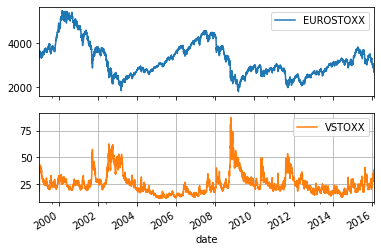

In [27]:
#시간의 흐름에 따른 추세 관측
data.plot(subplots = True)
plt.grid()
plt.show()


# 3. 주가 지수를 수익률로 환산(전장대비 수익률)
eurostoxx주가지수와 vstoxx 각각의 주가지수를 통한 수익률을 계산한 뒤 테스트

In [39]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot') #ggplot스타일 사용

In [37]:
#전날의 데이터를 분모로 하여 연산을 시켜준뒤 로그화
#데이터프레임화한 지수를 수익률로 환산하는 식 (전날 대비 이익)

#log화 한 값이 음수일 때 : 음의 수익률 / log화 한 값이 양수일 때 : 양의 수익률
rets = np.log(data / data.shift(1))  #df.shift(n) = 전체적인 행을 아래로 n칸 내리는 명령어

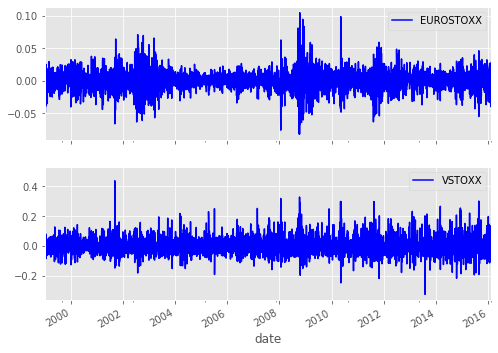

In [40]:
rets.plot(subplots=True,grid=True,style='b',figsize=(8,6))
plt.show()

# regression

In [41]:
import statsmodels.api as sm

In [42]:
model_sm = sm.OLS.from_formula("VSTOXX ~ EUROSTOXX", data=rets) #eurostoxx를 설명변수로 vstoxx예측

In [43]:
result_sm = model_sm.fit()
print(result_sm.summary()) #결정계수 0.543

                            OLS Regression Results                            
Dep. Variable:                 VSTOXX   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     5212.
Date:                Fri, 07 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:10:53   Log-Likelihood:                 7966.3
No. Observations:                4386   AIC:                        -1.593e+04
Df Residuals:                    4384   BIC:                        -1.592e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -9.51e-06      0.001     -0.016      0.9

### 상관계수

In [44]:
rets.corr() # 상당히 높은 음의 상관관계임을 알 수 있다.

EUROSTOXX   VSTOXX
EUROSTOXX    1.00000 -0.73698
VSTOXX      -0.73698  1.00000

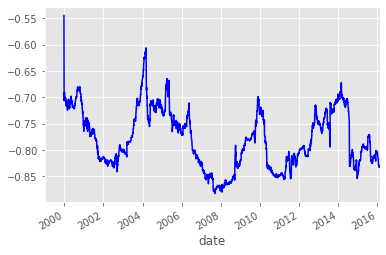

In [47]:
rets['EUROSTOXX'].rolling(window=252).corr(rets['VSTOXX']).plot(grid=True, style='b')
plt.show()

# finance데이터 및 주가, 주식 관련 데이터 수집

## 포트폴리오 최적화

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot') #ggplot스타일 사용

### finacedatareader은 금융 데이터를 다루는데 가장 기본이 되는 거래소별 전체 종목 코드와 가격데이터를 제공하는 역할을 한다.

1. 종목코드  
거래소별 전체 종목코드 - krx(kospi, kodaq, konex), nasdaq, nyse,amex, s&p 500시장의 정보를 제공

2. 가격데이터
해외주식 가격 데이터: AAPL(애플), AMZN(아마존), GOOG(구글) 등
국내주식 가격 데이터: 005930(삼성전자), 091990(셀트리온헬스케어) 등
각종 지수: KS11(코스피지수), KQ11(코스닥지수), DJI(다우지수), IXIC(나스닥 지수), US500(S&P 5000)
환율 데이터: USD/KRX (원달러 환율), USD/EUR(달러당 유로화 환율), CNY/KRW: 위엔화 원화 환율
암호화폐 가격: BTC/USD (비트코인 달러 가격, Bitfinex), BTC/KRW (비트코인 원화 가격, 빗썸)


데이터 컬럼 설명
Open = 시가 / High = 고가 / Low = 저가 / Close = 종가 / Volume = 거래량 / Change = 변동량

### 전체 종목 코드
한국
심볼	거래소
KRX	KRX 종목 전체
KOSPI	KOSPI 종목
KOSDAQ	KOSDAQ 종목
KONEX	KONEX 종목

미국
심볼	거래소
NASDAQ	나스닥 종목
NYSE	뉴욕 증권거래소 종목
AMEX	AMEX 종목
SP500	S&P 500 종목

### 1. 주가데이터 수집

#### 각 시장별 종목코드

In [63]:
import FinanceDataReader as fdr
fdr.__version__

'0.7.2'

In [66]:
# 한국거래소 상장종목 전체- 자동적으로 버전업을 하고 있음
df_krx = fdr.StockListing('KRX')
df_krx.head()

Symbol   Name         Sector  \
0  001250  GS글로벌      상품 종합 도매업   
1  082740  HSD엔진  일반 목적용 기계 제조업   
2  001390  KG케미칼    기초 화학물질 제조업   
3  011070  LG이노텍       전자부품 제조업   
4  010060    OCI    기초 화학물질 제조업   

                                            Industry  
0  수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...  
1                                     대형선박용엔진,내연발전엔진  
2                          콘크리트혼화제, 비료, 친환경농자재, 수처리제  
3                                        기타 전자부품 제조업  
4   타르제품,카본블랙,무수프탈산,농약원제,석탄화학제품,정밀화학제품,플라스틱창호재 제조,판매

In [64]:
len(df_krx)

2280

#### 가격 데이터 - 국내주식
데이터를 불러올 때 종목코드(symbol)를 사용

In [77]:
#fdr.DataReader(종목코드- symbol, 수집할 영역)
df = fdr.DataReader('011070','2018')

In [70]:
df.head(10)

Open    High     Low   Close   Volume    Change
Date                                                         
2018-01-02  147000  147000  142000  145000   270085  0.006944
2018-01-03  146000  148000  143500  147000   254861  0.013793
2018-01-04  148000  148500  144500  145000   186790 -0.013605
2018-01-05  146000  148000  143000  145500   236799  0.003448
2018-01-08  148000  148500  139500  142000   471519 -0.024055
2018-01-09  153500  160500  149000  156500  1239506  0.102113
2018-01-10  157000  157500  147500  149000   603263 -0.047923
2018-01-11  149500  150500  147000  150500   349462  0.010067
2018-01-12  149500  150000  142000  146000   524718 -0.029900
2018-01-15  145000  146000  143000  144500   140423 -0.010274

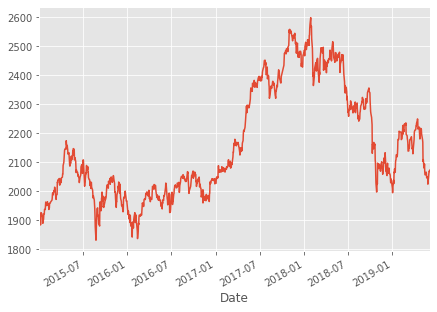

In [109]:
plt.figure(figsize=(7, 5))
df['Close'].plot()

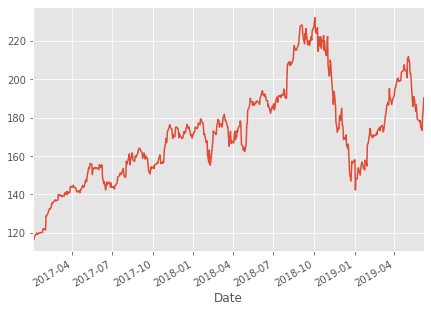

In [110]:
df = fdr.DataReader('AAPL','2017')
plt.figure(figsize = (7,5))
df['Close'].plot()

### 국가별 주가 지수 데이터 분석

한국 지수
심볼	설명
KS11	KOSPI 지수
KQ11	KOSDAQ 지수
KS50	KOSPI 50 지수
KS100	KOSPI 100
KRX100	KRX 100
KS200	코스피 200

미국 지수
심볼	설명
DJI	다우존스 지수
IXIC	나스닥 지수
US500	S&P 500 지수
VIX	S&P 500 VIX
※ DJI, IXIC, US500 가 미국 3대 지수

국가별 주요 지수
심볼	설명
JP255	닛케이 225 선물
STOXX50E	Euro Stoxx 50
CSI300	CSI 300 (중국)
HSI	항셍 (홍콩)
FTSE	영국 FTSE
DAX	독일 DAX 30
CAC	프랑스 CAC 40

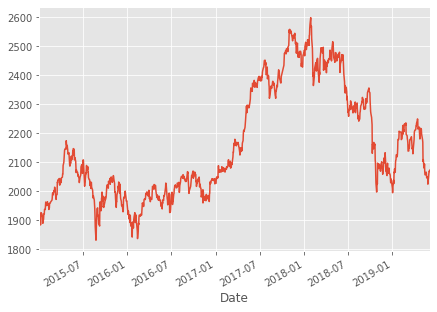

In [108]:
#ks11 (kospi지수), 2015~ 현재까지의 코스피지수 변동량
df = fdr.DataReader('KS11','2015')
plt.figure(figsize = (7,5))
df['Close'].plot()

### 국가별 환율 데이터 분석

심볼	설명
USD/KRW	달러당 원화 환율
USD/EUR	달러당 유로화 환율
USD/JPY	달러당 엔화 환율
CNY/KRW	위엔화 원화 환율
EUR/USD	유로화 달러 환율
USD/JPY	달러 엔화 환율
JPY/KRW	엔화 원화 환율
AUD/USD	오스트레일리아 달러 환율
EUR/JPY	유로화 엔화 환율
USD/RUB	달러 루블화

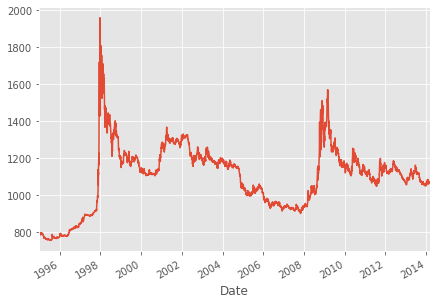

In [107]:
#원달러 환율
df = fdr.DataReader('USD/KRW', '1995')
plt.figure(figsize = (7,5))
df['Close'].plot()

### 코인(비트코인)등 암호화폐 가격 데이터 분석
-빗썸 제공

심볼	설명 (KRW)
BTC/KRW	비트코인 원화 가격
ETH/KRW	이더리움 원화 가격
XRP/KRW	리플 원화 가격
BCH/KRW	비트코인 캐시 원화 가격
EOS/KRW	이오스 원화 가격
LTC/KRW	라이트 코인 원화 가격
XLM/KRW	스텔라 원화 가격

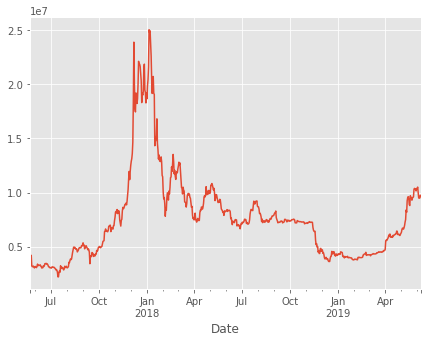

In [111]:
# 비트코인 원화 가격 (빗썸), 2016년~현재
df = fdr.DataReader('BTC/KRW', '2016')
plt.figure(figsize= (7,5))
df['Close'].plot()

# # 포트폴리오 즉, 분산투자를 통한 수익률 테스트 및 시뮬레이션

In [ ]:
stock_df=  pd.DataFrame()
symbols = ['AAPL', 'MSFT', 'DB', 'GLD']
for i in range(len(symbols)):
    cl0  = fdr.DataReader(symbols[i], '2015-01-01', '2018-01-01')
    stock_df[symbols[i]] = cl0['Close']
    

In [101]:
stock_df.head()

AAPL   MSFT     DB     GLD
Date                                    
2015-01-02  109.33  46.76  30.47  114.08
2015-01-05  106.25  46.33  28.82  115.80
2015-01-06  106.26  45.65  28.36  117.12
2015-01-07  107.75  46.23  28.66  116.43
2015-01-08  111.89  47.59  28.72  115.94

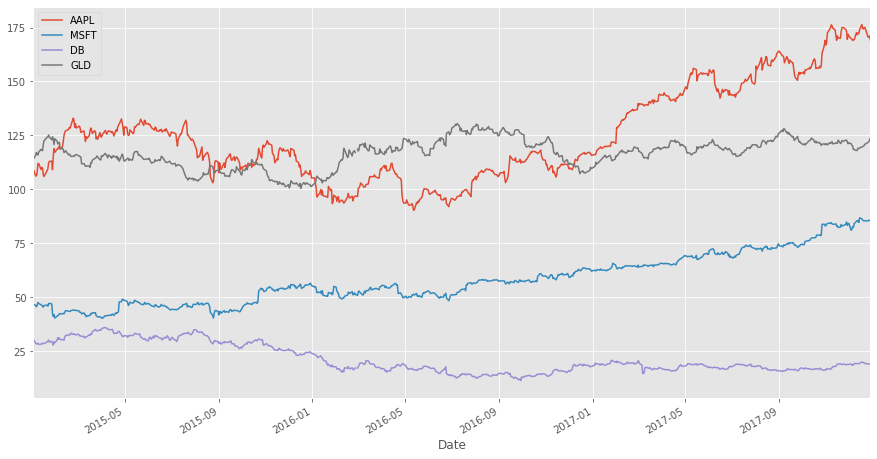

In [120]:
stock_df.plot(figsize=(15,8))
plt.show()

### 수익률 계산

In [121]:
rets = np.log(stock_df/stock_df.shift(1))

In [124]:
rets.cov() #*252 - 252를 왜 곱하지? #공분산 행렬을 구함
#252를 곱하는 이유 - 일간 파라미터로 계산된 값을 연간 파라미터로 변환하기 위해서
#1년에 장이 열리는 날인 252를 곱해준다.

AAPL      MSFT        DB       GLD
AAPL  0.052409  0.025679  0.021781 -0.004241
MSFT  0.025679  0.050653  0.026643 -0.004333
DB    0.021781  0.026643  0.182723 -0.013079
GLD  -0.004241 -0.004333 -0.013079  0.018554

### 포트폴리오 이론
포트폴리오 수익률 - 각 수익률의 기대수익률 sumation(wi*ui)
포트폴리오 분산 - E[(rp - up)^2]

In [142]:
np.random.seed(2)
weights = np.random.random(4) #noa= 5 - 가중치를 5개 만들어야하므로

In [143]:
weights /= np.sum(weights)# /= 기능은 가중치의 합을 1로 만들어주는 명령어

In [155]:
weights

array([ 0.30132911,  0.01791839,  0.37988817,  0.30086432])

In [145]:
#포트폴리오 기대수익률
np.sum(rets.mean() * weights) * 252

-0.0045308546290107879

In [157]:
#포트폴리오 분산
#np.dot - array로 되어 있는 행렬의 곱 / 엄밀히 말해서 array곱 연산
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.034645147584481201

In [158]:
#포트폴리오의 표준편차
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.18613207027398906

### 포트폴리오의 수익률 시뮬레이션

In [159]:
prets = [] #포트폴리오의 기대수익률
pvols = [] #포트폴리오의 위험 - 표준편차
num = 4
for p in range(2500):
    #random seed를 고정하지 않고 무작위로 2500개의 시뮬레이션을 돌린다.
    weights = np.random.random(num)
    weights /= np.sum(weights) #가중치의 합이 1이 되도록 변경
    
    #포트폴리오 기대수익률
    prets.append(np.sum(rets.mean() * weights) * 252)
    #포트폴리오의 표준편차
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

In [167]:
#전체적인 그래프 사이즈 고정으로 정하기
plt.rcParams["figure.figsize"] = (15,8)

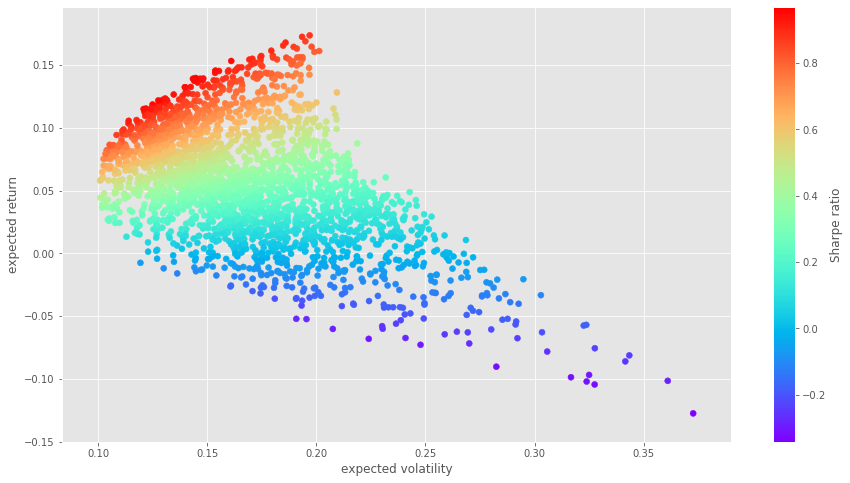

In [169]:
plt.scatter(pvols,prets, c= prets/pvols,marker='o',cmap = plt.cm.rainbow) 
#prets/pvols가 높을수록 변동량(포트폴리오 위험)에 비해서 수익률이 높은 것 = 샤프비율
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

### 포트폴리오 통계
수익률, 변동성, 샤프지수계산

In [ ]:
weights = np.random.random(num)

In [170]:
def statistics(weights):
    ''' weights = np.random.random(num)
    
    Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        포트폴리오 내의 증권 비중
    
    Returns
    =======
    pret : float
        포트폴리오 수익률의 기댓값
    pvol : float
        포트폴리오 변동성의 기댓값
    pret / pvol : float
        무위험 이자율이 0일 때의 포트폴리오 샤프 지수
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

### 샤프지수 최대화

In [171]:
import scipy.optimize as sco

In [172]:
def min_func_sharpe(weights):
    return -statistics(weights)[2] #array의 3번째 요소가 샤프지수를 구한 것이므로

In [173]:
#parameter1
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

In [175]:
#parameter2
bnds = tuple((0, 1) for x in range(4))
bnds

((0, 1), (0, 1), (0, 1), (0, 1))

In [177]:
#sco.minimize - ??
opts = sco.minimize(min_func_sharpe, 4 * [1. / 4,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [178]:
opts

     fun: -0.9740288349817686
     jac: array([  4.48524952e-05,   3.65450978e-05,   1.79719230e+00,
        -7.94604421e-05])
 message: 'Optimization terminated successfully.'
    nfev: 50
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([  1.72676093e-01,   4.99873665e-01,   8.92623649e-16,
         3.27450243e-01])

In [180]:
statistics(opts['x'].round(3))

array([ 0.13341491,  0.13697228,  0.97402853])

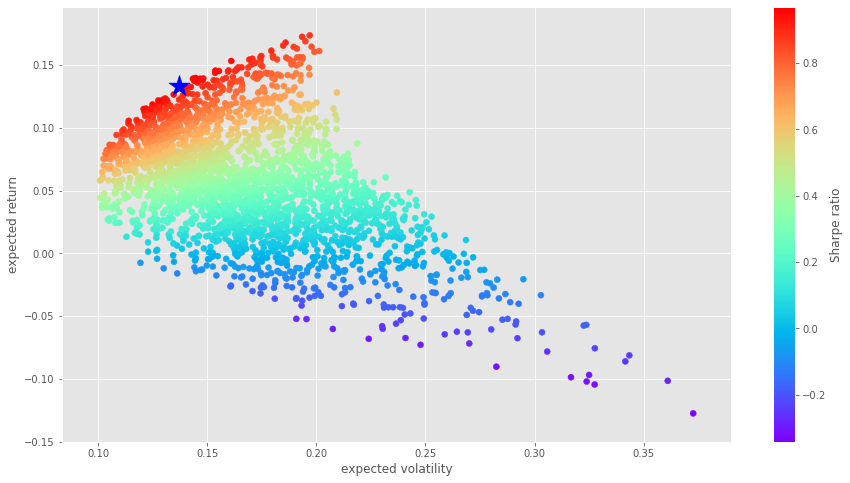

In [183]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=plt.cm.rainbow)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

#pt_opts -  수익률, 변동량, 샤프지수를 반환해주는 함수 값을 저장해놓은 변수
pt_opts = statistics(opts['x']).round(3)
plt.scatter(pt_opts[1], pt_opts[0],c = 'b',marker="*", s=500, alpha=1)
plt.show()

### 포트폴리오 분산 최소화

In [184]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2 
#기존의 statistics함수로 도출한 변동량은 표준편차이기 때문에 분산을 구하기 위해서는 제곱을 해줘야함

In [186]:
optv = sco.minimize(min_func_variance, 4 * [1. / 4,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [187]:
optv['x'].round(3)

array([ 0.143,  0.148,  0.061,  0.648])

In [188]:
statistics(optv['x']).round(3)

array([ 0.056,  0.1  ,  0.559])

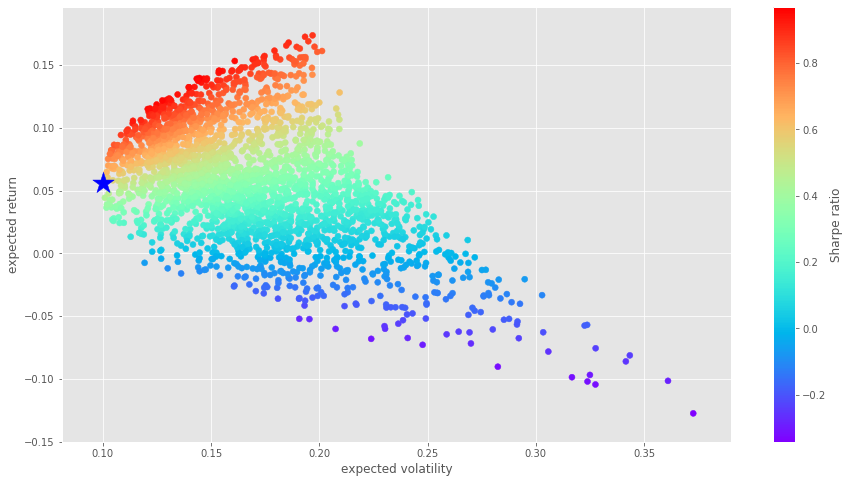

In [189]:
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap=plt.cm.rainbow)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

pt_optv = statistics(optv['x']).round(3)
plt.scatter(pt_optv[1], pt_optv[0], marker="*", s=500, alpha=1,c='b')
plt.show()

### 효율적 투자선
목표 위험 수준에 대해 최대 수익률을 가지는 모든 포트폴리오의 집합

In [190]:
#파라미터가 어떤식으로 들어가야 원하는 데이터를 뽑을 수 있는지 연구해봐야할 듯...
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)

In [191]:
def min_func_port(weights):
    return statistics(weights)[1]

In [201]:
trets = np.linspace(0.0, 0.25, 50)#0 ~ 0.25까지 랜덤으 50개를 반환
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, 4 * [1. / 4,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun']) #fun값이 어떤 값을 반환해주는 거지...
tvols = np.array(tvols)

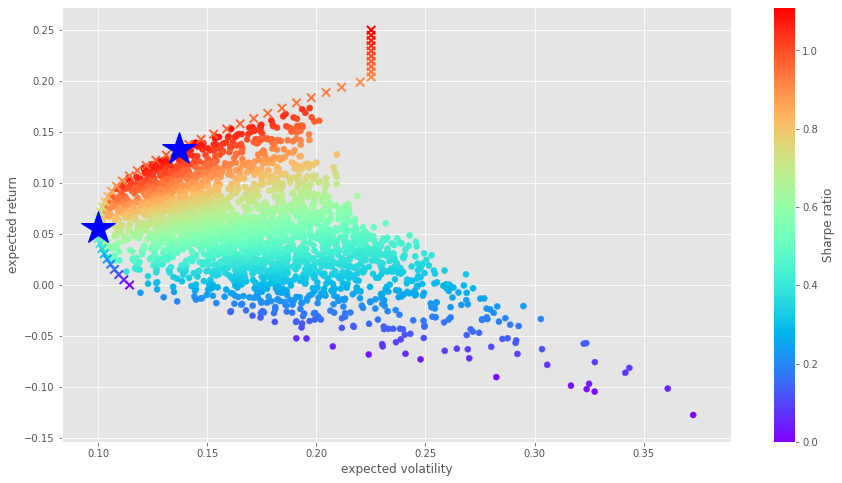

효율적 투자선에서 최소 분산 포트폴리오 밑의 부분을 자르고 선을 그으면 스플라인 함수를 그릴 수 있다. 


In [203]:
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o', cmap=plt.cm.rainbow)
            # 무작위 포트폴리오
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x', s=70, linewidth=2, cmap=plt.cm.rainbow)
            # 효율적 투자선
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=35,c='b')
            # 최대 샤프 지수를 가진 포트폴리오
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],
         'y*', markersize=35,c='b')
            # 최소 분산 포트폴리오
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()
print('효율적 투자선에서 최소 분산 포트폴리오 밑의 부분을 자르고 선을 그으면 스플라인 함수를 그릴 수 있다. ')

### 자본시장선
무위험 자산을 포함한 최적 포트폴리오 집합  
  
무위험 자산을 지니며 효율적 투자선(스플라인)에 접하는 직선

In [ ]:
#자본시장선에 대해서 이론적으로는 알고있지만 직접 코딩을 하는 과정에서 계산식을 이해하는데 한계가 있기 때문에
#공부를 더 해야할 듯
def eqations(p,rf = 0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] *p[2] - f(p[2])
    eq3 = p[1] - df(p[2])